In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from PIL import Image
import torch.nn.functional as F
import matplotlib.pyplot as plt

/home/nurbo/Desktop/Fall 2023/CSCI 344 Data Mining and Decision Support/Lab Assignments/Lab Assignment 10/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(torch.cuda.is_available())

True


In [3]:
# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Set the path to your project folder
project_folder = '.'

# Set the path to the train and test data folders
train_data_dir = os.path.join(project_folder, "data", "train")
test_data_dir = os.path.join(project_folder, "data", "test")

# Load file names and labels for training
cat_images = [os.path.join(train_data_dir, "cat", file) for file in os.listdir(os.path.join(train_data_dir, "cat"))]
dog_images = [os.path.join(train_data_dir, "dog", file) for file in os.listdir(os.path.join(train_data_dir, "dog"))]

# Assign labels (0 for cat, 1 for dog)
labels = [0] * len(cat_images) + [1] * len(dog_images)

# Combine file names and labels
file_names = cat_images + dog_images

# Split the data into training and validation sets
train_files, val_files, train_labels, val_labels = train_test_split(file_names, labels, test_size=0.2, random_state=42)

# Image data augmentation for training
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

# Image data augmentation for validation
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

In [4]:
class CustomDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        # Check if labels are provided
        if self.labels is not None:
            label = torch.tensor(self.labels[idx], dtype=torch.float32)
            return img, label
        else:
            return img

In [5]:
# Define batch size
batch_size = 32

# Create custom datasets and dataloaders
train_dataset = CustomDataset(train_files, train_labels, transform=train_transform)
val_dataset = CustomDataset(val_files, val_labels, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [6]:
# Define and train the Convolutional Neural Network (CNN) model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x

model_cnn = CNNModel()

# Display the model summary
print(model_cnn)

model_cnn.to(device)

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
)


CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
)

In [7]:
# Loss and optimizer
criterion = nn.BCELoss()
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=0.001)

In [8]:

# Train the CNN model
cnn_num_epochs = 20

validation_accuracies_cnn = []  # List to store validation accuracies

for epoch in range(cnn_num_epochs):
    model_cnn.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_cnn.zero_grad()
        outputs = model_cnn(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer_cnn.step()

    # Validation
    model_cnn.eval()
    with torch.no_grad():
        val_predictions_cnn = []
        val_labels_list = []
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            val_outputs = model_cnn(inputs)
            val_predictions_cnn.extend(val_outputs.cpu().numpy())
            val_labels_list.extend(labels.cpu().numpy())

        val_predictions_cnn = np.round(np.array(val_predictions_cnn)).flatten()
        accuracy_cnn = accuracy_score(val_labels_list, val_predictions_cnn)
        validation_accuracies_cnn.append(accuracy_cnn)  # Save accuracy for plotting
        print(f"Epoch [{epoch+1}/{cnn_num_epochs}], Validation Accuracy (CNN): {accuracy_cnn}")

Epoch [1/20], Validation Accuracy (CNN): 0.5476
Epoch [2/20], Validation Accuracy (CNN): 0.6514
Epoch [3/20], Validation Accuracy (CNN): 0.7206
Epoch [4/20], Validation Accuracy (CNN): 0.7466
Epoch [5/20], Validation Accuracy (CNN): 0.7588
Epoch [6/20], Validation Accuracy (CNN): 0.7792
Epoch [7/20], Validation Accuracy (CNN): 0.8062
Epoch [8/20], Validation Accuracy (CNN): 0.8088
Epoch [9/20], Validation Accuracy (CNN): 0.821
Epoch [10/20], Validation Accuracy (CNN): 0.835
Epoch [11/20], Validation Accuracy (CNN): 0.8272
Epoch [12/20], Validation Accuracy (CNN): 0.841
Epoch [13/20], Validation Accuracy (CNN): 0.8534
Epoch [14/20], Validation Accuracy (CNN): 0.8406
Epoch [15/20], Validation Accuracy (CNN): 0.8532
Epoch [16/20], Validation Accuracy (CNN): 0.861
Epoch [17/20], Validation Accuracy (CNN): 0.861
Epoch [18/20], Validation Accuracy (CNN): 0.8604
Epoch [19/20], Validation Accuracy (CNN): 0.8586
Epoch [20/20], Validation Accuracy (CNN): 0.869


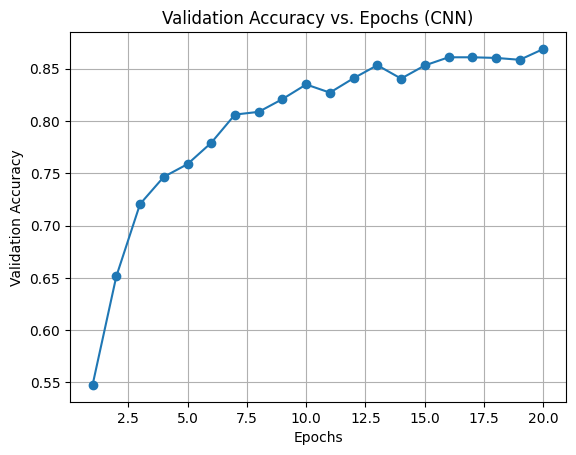

In [9]:
# Plot the validation accuracies of CNN
plt.plot(range(1, cnn_num_epochs + 1), validation_accuracies_cnn, marker='o')
plt.title('Validation Accuracy vs. Epochs (CNN)')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()

In [10]:
# Define and train the Transfer Learning model using MobileNet
class TransferLearningModel(nn.Module):
    def __init__(self):
        super(TransferLearningModel, self).__init__()
        mobilenet = models.mobilenet_v2(pretrained=True)
        self.features = mobilenet.features
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(1280, 1)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = torch.sigmoid(self.fc(x))
        return x

model_transfer = TransferLearningModel()

# Display the model summary
print(model_transfer)

# Set device
model_transfer.to(device)

# Loss and optimizer
optimizer_transfer = optim.Adam(model_transfer.parameters(), lr=0.001)

TransferLearningModel(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2

/home/nurbo/Desktop/Fall 2023/CSCI 344 Data Mining and Decision Support/Lab Assignments/Lab Assignment 10/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nurbo/Desktop/Fall 2023/CSCI 344 Data Mining and Decision Support/Lab Assignments/Lab Assignment 10/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
# Train the Transfer Learning model

tl_num_epochs = 10

validation_accuracies_transfer = []  # List to store validation accuracies

for epoch in range(tl_num_epochs):
    model_transfer.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_transfer.zero_grad()
        outputs = model_transfer(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer_transfer.step()

    # Validation
    model_transfer.eval()
    with torch.no_grad():
        val_predictions_transfer = []
        val_labels_list = []
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            val_outputs = model_transfer(inputs)
            val_predictions_transfer.extend(val_outputs.cpu().numpy())
            val_labels_list.extend(labels.cpu().numpy())

        val_predictions_transfer = np.round(np.array(val_predictions_transfer)).flatten()
        accuracy_transfer = accuracy_score(val_labels_list, val_predictions_transfer)
        validation_accuracies_transfer.append(accuracy_transfer)  # Save accuracy for plotting
        print(f"Epoch [{epoch+1}/{tl_num_epochs}], Validation Accuracy (Transfer Learning): {accuracy_transfer}")

Epoch [1/10], Validation Accuracy (Transfer Learning): 0.955
Epoch [2/10], Validation Accuracy (Transfer Learning): 0.951
Epoch [3/10], Validation Accuracy (Transfer Learning): 0.9654
Epoch [4/10], Validation Accuracy (Transfer Learning): 0.9654
Epoch [5/10], Validation Accuracy (Transfer Learning): 0.9604
Epoch [6/10], Validation Accuracy (Transfer Learning): 0.9524
Epoch [7/10], Validation Accuracy (Transfer Learning): 0.9692
Epoch [8/10], Validation Accuracy (Transfer Learning): 0.9454
Epoch [9/10], Validation Accuracy (Transfer Learning): 0.9718
Epoch [10/10], Validation Accuracy (Transfer Learning): 0.972


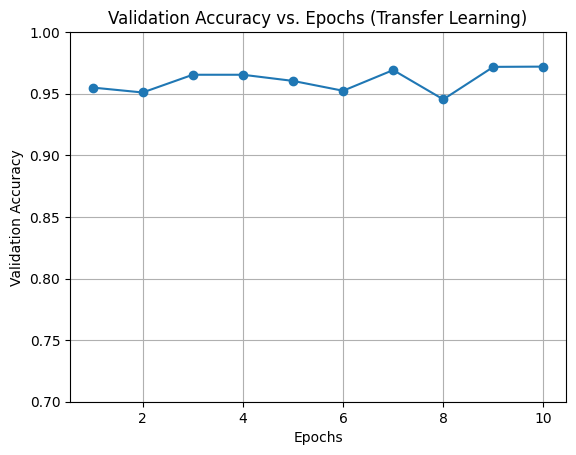

In [17]:
# Plot the validation accuracies for Transfer Learning
plt.plot(range(1, tl_num_epochs + 1), validation_accuracies_transfer, marker='o')
plt.title('Validation Accuracy vs. Epochs (Transfer Learning)')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.ylim(0.7, 1.0)
plt.grid(True)
plt.show()

In [21]:
# Choose the best model (the one with higher validation accuracy)

print(f"CNN model accuracy: {accuracy_cnn}")
print(f"Transfer model accuracy: {accuracy_transfer}")
chosen_model = model_cnn if accuracy_cnn > accuracy_transfer else model_transfer

CNN model accuracy: 0.869
Transfer model accuracy: 0.972


In [22]:
# Generate test data
test_files = [os.path.join(test_data_dir, file) for file in os.listdir(test_data_dir)]

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

test_dataset = CustomDataset(test_files, labels=None, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [23]:
test_predictions = []

def test_model(model, test_loader, test_predictions):
  model.eval()
  with torch.no_grad():
      for inputs in test_loader:
          inputs = inputs.to(device)
          outputs = model(inputs)
          print(outputs)
          test_predictions.extend(outputs.cpu().numpy())

# Make predictions on the test set using the best model
test_model(chosen_model, test_loader, test_predictions)

# # Make predictions on the test set using the cnn model
# test_model(model_cnn, test_loader, test_predictions)

# # Make predictions on the test set using the transfer model
# test_model(model_transfer, test_loader, test_predictions)

tensor([[1.0000e+00],
        [3.3326e-01],
        [9.8980e-10],
        [9.9960e-01],
        [7.8315e-01],
        [5.8048e-07],
        [1.1944e-07],
        [1.6862e-01],
        [8.9706e-08],
        [8.9944e-06],
        [1.5687e-07],
        [9.9810e-01],
        [8.9013e-01],
        [4.0210e-11],
        [1.7164e-08],
        [9.9956e-01],
        [9.7226e-07],
        [1.0000e+00],
        [9.8530e-02],
        [1.5026e-13],
        [9.9823e-01],
        [9.0451e-01],
        [9.7678e-01],
        [3.1604e-02],
        [2.9852e-12],
        [9.6779e-13],
        [9.9998e-01],
        [6.1116e-10],
        [1.2772e-09],
        [1.0392e-10],
        [1.3357e-07],
        [9.7077e-05]], device='cuda:0')
tensor([[3.3166e-14],
        [9.9999e-01],
        [3.0000e-06],
        [4.7321e-05],
        [1.0526e-10],
        [1.0000e+00],
        [2.5366e-09],
        [6.0539e-10],
        [9.9144e-01],
        [7.2664e-01],
        [1.1429e-01],
        [9.9968e-01],
        [8.938

In [24]:
# Create a DataFrame with image IDs and corresponding probabilities
image_ids = [int(file.split('.')[0]) for file in os.listdir(test_data_dir)]
submission_df = pd.DataFrame({'id': image_ids, 'label': np.array(test_predictions).flatten()})

# Save the DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)